# TTT Gradient Analysis

Comparing surrogate vs non-surrogate gradients for k, q, v inputs.

In [1]:
import jax
import jax.numpy as jnp
from flax import nnx
from flax.nnx import rnglib as rng
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '../../..')

from ueaj.model.ttt import TTTModel
from ueaj.model import GMLP

In [2]:
# Config
model_d, hidden_d = 128, 512
batch_size, seq_len = 1, 200
seed = 42

In [3]:
# Create models
model_surr = TTTModel(model_d, hidden_d, GMLP, surrogate=True, rngs=rng.Rngs(seed))
model_nonsurr = TTTModel(model_d, hidden_d, GMLP, surrogate=False, rngs=rng.Rngs(seed))

# Generate k, q, v directly
key = jax.random.PRNGKey(123)
k_key, v_key, q_key = jax.random.split(key, 3)
k = jax.random.normal(k_key, (batch_size, seq_len, hidden_d))
v = jax.random.normal(v_key, (batch_size, seq_len, hidden_d))
q = jax.random.normal(q_key, (batch_size, seq_len, hidden_d))

print(f"k, v, q shapes: {k.shape}")

k, v, q shapes: (1, 200, 512)


In [4]:
def compute_grads(model, k, v, q, grad_output):
    """Compute gradients w.r.t. k, v, q using VJP."""
    def forward(k, v, q):
        return model.apply_ttt(k, v, q)
    
    output, vjp_fn = jax.vjp(forward, k, v, q)
    grad_k, grad_v, grad_q = vjp_fn(grad_output)
    return grad_k, grad_v, grad_q, output

def rms_error_per_token(grad_surr, grad_nonsurr):
    """Compute RMS error per token position, averaged over batch."""
    diff = grad_surr - grad_nonsurr
    rms_per_batch = jnp.sqrt(jnp.mean(diff**2, axis=2))  # (batch, seq_len)
    return rms_per_batch.mean(axis=0)  # (seq_len,)

def rms_norm_per_token(grad):
    """Compute RMS norm per token position, averaged over batch."""
    rms_per_batch = jnp.sqrt(jnp.mean(grad**2, axis=2))  # (batch, seq_len)
    return rms_per_batch.mean(axis=0)  # (seq_len,)

def cosine_similarity_per_token(grad_surr, grad_nonsurr):
    """Compute cosine similarity per token position, averaged over batch."""
    # Compute per batch element
    dot_product = jnp.sum(grad_surr * grad_nonsurr, axis=2)  # (batch, seq_len)
    norm_surr = jnp.linalg.norm(grad_surr, axis=2)  # (batch, seq_len)
    norm_nonsurr = jnp.linalg.norm(grad_nonsurr, axis=2)  # (batch, seq_len)
    cosine_sim = dot_product / (norm_surr * norm_nonsurr + 1e-8)  # (batch, seq_len)
    return cosine_sim.mean(axis=0)  # (seq_len,)

In [5]:
# Random output gradient
grad_output = jax.random.normal(jax.random.PRNGKey(456), (batch_size, seq_len, hidden_d))

# Compute gradients
print("Computing gradients...")
gk_surr, gv_surr, gq_surr, _ = compute_grads(model_surr, k, v, q, grad_output)
gk_nonsurr, gv_nonsurr, gq_nonsurr, _ = compute_grads(model_nonsurr, k, v, q, grad_output)
print("✓ Done")

Computing gradients...
dk [[[ 9.823946    0.24769163 10.612463   ...  5.011695   11.590538
    4.2276726 ]
  [ 1.3232763  10.971563   -0.6932125  ... 13.008151   -0.76324844
   14.597281  ]
  [-1.5273209  -8.86121    -4.1389027  ... 19.385317   -5.6488433
   -1.4168358 ]
  ...
  [-0.15185472 -2.1279984  -1.6993189  ...  1.2666335  -0.7969079
   -1.9698261 ]
  [-3.0666366   1.3935276   1.8836765  ... -1.0718899  -2.1860237
    0.90038097]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]]
✓ Done


In [6]:
# Compute metrics per token
cos_k = cosine_similarity_per_token(gk_surr, gk_nonsurr)
cos_v = cosine_similarity_per_token(gv_surr, gv_nonsurr)
rms_q = rms_error_per_token(gq_surr, gq_nonsurr)

norm_q = rms_norm_per_token(gq_nonsurr)

print(f"Cosine similarity ranges:")
print(f"  k: [{cos_k.min():.4f}, {cos_k.max():.4f}]")
print(f"  v: [{cos_v.min():.4f}, {cos_v.max():.4f}]")
print(f"RMS error range:")
print(f"  q: [{rms_q.min():.4f}, {rms_q.max():.4f}]")

Cosine similarity ranges:
  k: [-0.4565, 0.3614]
  v: [-0.5208, 0.7992]
RMS error range:
  q: [0.0000, 0.0000]


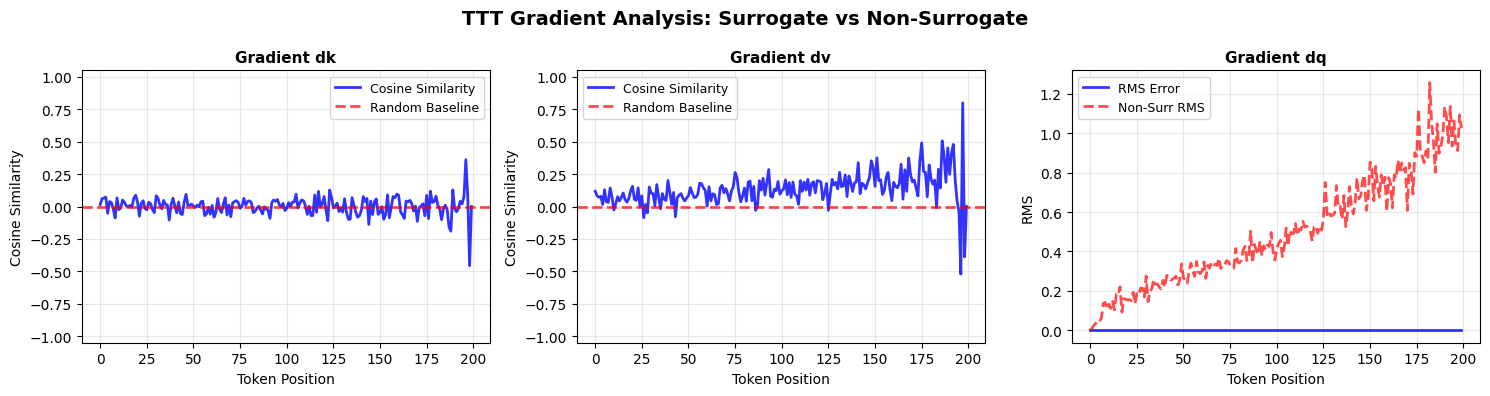

✓ Saved as 'ttt_gradient_comparison.png'


In [7]:
# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('TTT Gradient Analysis: Surrogate vs Non-Surrogate', fontsize=14, fontweight='bold')

tokens = np.arange(seq_len)

# k: Cosine similarity
axes[0].plot(tokens, cos_k, 'b-', linewidth=2, label='Cosine Similarity', alpha=0.8)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Random Baseline', alpha=0.7)
axes[0].set_xlabel('Token Position', fontsize=10)
axes[0].set_ylabel('Cosine Similarity', fontsize=10)
axes[0].set_title('Gradient dk', fontsize=11, fontweight='bold')
axes[0].set_ylim(-1.05, 1.05)
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# v: Cosine similarity
axes[1].plot(tokens, cos_v, 'b-', linewidth=2, label='Cosine Similarity', alpha=0.8)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Random Baseline', alpha=0.7)
axes[1].set_xlabel('Token Position', fontsize=10)
axes[1].set_ylabel('Cosine Similarity', fontsize=10)
axes[1].set_title('Gradient dv', fontsize=11, fontweight='bold')
axes[1].set_ylim(-1.05, 1.05)
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

# q: RMS error
axes[2].plot(tokens, rms_q, 'b-', linewidth=2, label='RMS Error', alpha=0.8)
axes[2].plot(tokens, norm_q, 'r--', linewidth=2, label='Non-Surr RMS', alpha=0.7)
axes[2].set_xlabel('Token Position', fontsize=10)
axes[2].set_ylabel('RMS', fontsize=10)
axes[2].set_title('Gradient dq', fontsize=11, fontweight='bold')
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ttt_gradient_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved as 'ttt_gradient_comparison.png'")

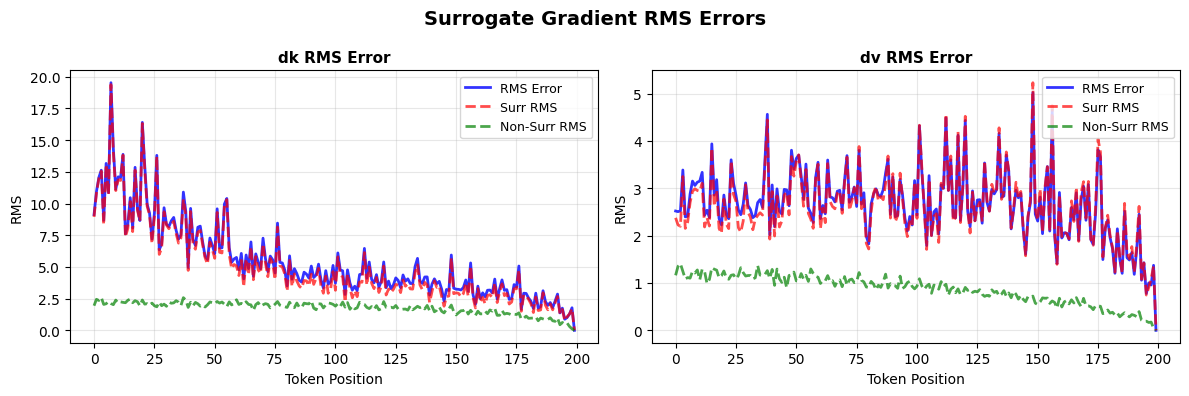

✓ Saved as 'ttt_gradient_rms_errors.png'


In [8]:
# Plot RMS errors for dk and dv with surrogate and non-surrogate RMS for scale
rms_k = rms_error_per_token(gk_surr, gk_nonsurr)
rms_v = rms_error_per_token(gv_surr, gv_nonsurr)
norm_k_surr = rms_norm_per_token(gk_surr)
norm_v_surr = rms_norm_per_token(gv_surr)
norm_k_nonsurr = rms_norm_per_token(gk_nonsurr)
norm_v_nonsurr = rms_norm_per_token(gv_nonsurr)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Surrogate Gradient RMS Errors', fontsize=14, fontweight='bold')

tokens = np.arange(seq_len)

# dk RMS error
axes[0].plot(tokens, rms_k, 'b-', linewidth=2, label='RMS Error', alpha=0.8)
axes[0].plot(tokens, norm_k_surr, 'r--', linewidth=2, label='Surr RMS', alpha=0.7)
axes[0].plot(tokens, norm_k_nonsurr, 'g--', linewidth=2, label='Non-Surr RMS', alpha=0.7)
axes[0].set_xlabel('Token Position', fontsize=10)
axes[0].set_ylabel('RMS', fontsize=10)
axes[0].set_title('dk RMS Error', fontsize=11, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# dv RMS error
axes[1].plot(tokens, rms_v, 'b-', linewidth=2, label='RMS Error', alpha=0.8)
axes[1].plot(tokens, norm_v_surr, 'r--', linewidth=2, label='Surr RMS', alpha=0.7)
axes[1].plot(tokens, norm_v_nonsurr, 'g--', linewidth=2, label='Non-Surr RMS', alpha=0.7)
axes[1].set_xlabel('Token Position', fontsize=10)
axes[1].set_ylabel('RMS', fontsize=10)
axes[1].set_title('dv RMS Error', fontsize=11, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ttt_gradient_rms_errors.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved as 'ttt_gradient_rms_errors.png'")